In [4]:
import sys
import os
import pandas as pd
import numpy as np

from collections import Counter
from bareunpy._tagger import Tagger, Tagged
from bareunpy._tokenizer import Tokenizer, Tokenized
from bareunpy._custom_dict import CustomDict
from bareunpy._custom_dict_client import CustomDictionaryServiceClient
from bareunpy._lang_service_client import BareunLanguageServiceClient

import json
from sys import stdout
from typing import IO, List, Any, Union

# 데이터 전처리 알고리즘
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler


import bareunpy as brn
from google.protobuf.json_format import MessageToDict
import grpc
from bareunpy._custom_dict import CustomDict
from bareunpy._lang_service_client import BareunLanguageServiceClient, MAX_MESSAGE_LENGTH
from bareun.language_service_pb2 import AnalyzeSyntaxResponse, AnalyzeSyntaxListResponse, Morpheme, Sentence, Token

In [ ]:
# 리뷰 출력시 ... 없이 전부 나오게 설정
pd.set_option('display.max_colwidth', None)
#pd.set_option('display.max_columns', None)
#pd.set_option('display.width', None)
pd.set_option('display.max_rows', None)

In [ ]:
naver_shopping = pd.read_csv(r'C:\Users\NT550\asac\SIH\SIH\code2\result\naver_shopping_review.csv')
naver_shopping['제품명'].value_counts()

In [ ]:
# df_review = review for review in naver_shopping['리뷰'] if review == str 
df_review = [review for review in naver_shopping['리뷰'] if type(review) is str]
df_review

In [ ]:
# 한글 외의 모든 글자를 제거한다.
# 한글 정규식을 이용하여 한글 외의 모든 글자를 제거한다.

import re

def text_clearing(text):
    if isinstance(text, str):  # 값이 문자열인 경우에만 처리
        hangul = re.compile('[^ ㄱ-ㅣ가-힣]+')
        result = hangul.sub('', text)
        return result
    else:
        return ""


In [ ]:
naver_shopping["ko_review"] = naver_shopping["리뷰"].apply(lambda x : text_clearing(x))

In [ ]:
#naver_shopping.to_csv('naver_shopping.csv')

### bareunpy 예시

In [ ]:
#bareunpy 예시

#import bareunpy as brn
#tagger = brn.Tagger(apikey="kpba-YOURKEY", domain="custom")
#>>> print(tagger.morphs('안녕하세요, 반가워요.'))
#['안녕', '하', '시', '어요', ',', '반갑', '어요', '.']
#>>> print(tagger.nouns('나비 허리에 새파란 초생달이 시리다.'))
#['나비', '허리', '초생달']
#>>> print(tagger.pos('햇빛이 선명하게 나뭇잎을 핥고 있었다.'))
#[('햇빛', 'NNG'), ('이', 'JKS'), ('선명', 'NNG'), ('하', 'XSA'), ('게', 'EC'), ('나뭇잎', 'NNG'),
    #('을', 'JKO'), ('핥', 'VV'), ('고', 'EC'), ('있', 'VX'), ('었', 'EP'), ('다', 'EF'), ('.', 'SF')]

In [5]:
tagger = brn.Tagger(apikey="koba-YGC27UA-OD3UPJY-VOIHT3I-G6IKLNA", domain="custom")

### 불용어 처리

In [ ]:
import nltk
nltk.download('stopwords')

In [ ]:
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize 

In [10]:
rm_nouns = ['것', '씩', 'ㅎ', '거', '저', 'ㅎㅎ', '들', '포', '꿀', '스틱', '구매', '용', '형', '하나', '수', '개', '소',
            '번', '1', 'ㅋ', '중', '굿', '분', '요', '편', '듯', '적', '님', '나', '제', '대', '비', '전', '뭐', '몇',
            '데', '만', '다', '떼', '날', '꺼', '겸', '점', '이', '성', '이거', 'ㅋㅋㅋㅋ', 'ㅎㅎㅎ', '등', '1', '2', '3', '디', '년',
            '그거', '재', '재재재', '벌꿀']#선물

stop_words = ['구매','제품','샘플','꿀','스틱','사용기','뭐','달','수','날','데','저','이번','ㅎ','포','ㅋ','ㅋㅋ','ㅎㅎ','ㅠ','ㅠㅠ','ㅜ','ㅜㅜ','달',
              '거','것','꺼','어용','앞','저희','나','저','점','전','포','후','이', '있', '하', '것', '들', '그', '되', '수', '이',
              '보','데', '듣','제','분','이거','번','손''않', '없', '나', '사람', '주', '아니', '등', '같', '우리', '때', '년', '가',
              '한', '지', '대하', '오', '말', '일', '그렇', '위하','으','잘','시','ㅡ','만','개','선물']

stop_word = ['꿀','제품','섭취','꽃','하루','벌꿀','생각','스틱','허니','사용','리버','저','포','추천','품','생각','구매','요즘','맛집','프로필',
      '블로거','블로그','꿀라보','입','가능','비','어디','생산','벌','안','식품','판매','주문','정도','마음','위','소개','종류','후','상품',
      '접기','펴기','방법','준비','날','이번','오늘','전','종','손','안녕하세요','곳','속','시간','이상','후기', '달','나무','점','잔','확인',
      '이하','최고','원','컷','리뷰','이거','경우','엔젯허니','근','처음','박','이지','타임','일상','덕','유통','추가','산','글','시작','일반',
      '다음','사진','시','저희','포스팅','이웃','정보','약','꽃꿀','개봉','제','밀','힐링','세계','팜','끝','이야기','소','아래','누구','구입',
      '당귀','맘','힐러','각종','개인','여기','이것','택배','이름','세상','미', '푸드','힘','넷','이유','컵','이용','링크','작성','과정',
      '비해피네이처','중요','아티키','프로','참고','청','돌','진행','굿','종이','라보','무엇','주','문의','카페','완성','대','비케어풀',
      '연','보기','이벤트','조금','도착','피나무','선','무료','공구','범','반','미만','맛집','사항','앞','돈','공부','허니바이허니','사실',
      '오픈','관심','생','밥','차이','튜브','봉','알타이','반품','국','인','0','간','홈페이지','라보리오사꿀','유튜브','사용기','뭐',
      '수','ㅎ','ㅎㅎ','ㅋ','ㅋㅋ','ㅠ','ㅠㅠ','ㅜ','ㅜㅜ','거','꺼','것','용','나','이', '있','하','들','등','보','데','듣','제','분',
      '번','않','없','사람','주','같','때','년','한']



final_list = list(set(rm_nouns + stop_words + stop_word))
print(final_list)

['처음', '종', '원', '추가', '추천', '손', '비케어풀', '홈페이지', '미', '하루', '대하', '그렇', '링크', '샘플', '진행', '약', '택배', '앞', '지', '허니', '이야기', '이것', '위', '겸', 'ㅎ', '오픈', '없', '전', '한', '입', '오늘', '작성', '누구', '푸드', '사항', '적', '잔', '컷', '선', '개인', '문의', '간', '사용기', '넷', '주', '돈', '속', '번', '일반', '완성', '성', '세상', '섭취', '곳', '리뷰', '유통', '종류', '이용', '펴기', '손않', '박', '중', '사용', '등', '아래', '나', '않', '마음', '이', '근', '나무', '공부', '선물', '컵', '비해피네이처', '맘', '반', '종이', '밀', '경우', '미만', '프로', '알타이', '잘', '달', '소개', 'ㅠㅠ', 'ㅋ', '같', 'ㅜ', '사람', '우리', '다음', '힐링', '굿', '있', '이유', '개', '요', '방법', '이거', '개봉', '하나', '들', '그거', '무엇', '생', '중요', '이하', '연', '가능', '힘', '날', '어용', '후', '요즘', '사진', '과정', '준비', '청', '끝', '라보', '정도', '팜', '스틱', '반품', '안녕하세요', '시작', '용', '저희', 'ㅜㅜ', '소', '구입', '재', '대', '도착', '떼', '상품', '판매', '범', '관심', '분', '산', 'ㅠ', 'ㅎㅎ', '각종', '가', '생각', '이지', '사실', '국', '시간', '아티키', '확인', '것', '말', '세계', '블로거', '포스팅', '보기', '어디', '타임', '그', '유튜브', '편', 'ㅡ', '위하', '품', '꽃', '되', '피나무', '조금', 'ㅋㅋㅋㅋ', '벌꿀', '밥', '주문

In [ ]:
fin

### bareunpy 토큰화

In [ ]:
# bareunpy 라이브러리로 텍스트 데이터에서 형태소를 추출.
def get_pos (x) :
    pos = tagger.pos(x)
    
    # 단어와 품사를 합쳐서 하나의 단어로 만들어준다.
    result = []
    
    # 형태소의 수만큼 반복한다.
    # 조사인 것과 명사인 것이 같을 수 있기 때문에 구분해준다.
    # 형태소 벡터를 만들때 추후 사용
    for a1 in pos :
        result.append(f'{a1[0]}/{a1[1]}')
    
    return result

In [ ]:
# bareunpy 라이브러리로 텍스트 데이터에서 형태소를 추출.
def get_nouns (x) :
    pos = tagger.nouns(x)
    
    # 단어와 품사를 합쳐서 하나의 단어로 만들어준다.
    result = []
    
    # 형태소의 수만큼 반복한다.
    # 조사인 것과 명사인 것이 같을 수 있기 때문에 구분해준다.
    # 형태소 벡터를 만들때 추후 사용
    for a1 in pos :
        result.append(f'{a1[0]}/{a1[1]}')
    
    return result

In [ ]:
# bareunpy 라이브러리로 텍스트 데이터에서 형태소를 추출.
def get_verb (x) :
    pos = tagger.verbs(x)
    
    # 단어와 품사를 합쳐서 하나의 단어로 만들어준다.
    result = []
    
    # 형태소의 수만큼 반복한다.
    # 조사인 것과 명사인 것이 같을 수 있기 때문에 구분해준다.
    # 형태소 벡터를 만들때 추후 사용
    for a1 in pos :
        result.append(f'{a1[0]}/{a1[1]}')
    
    return result

In [6]:
print(tagger.morphs('요즘 커피 대신 마누카허니 꿀차 타서 마시기도 하고요.  제가 애정 하는 아임힐링 엔젯허니 마누카꿀은 뉴질랜드산 백 프로이기 때문이에요.'))
print(tagger.nouns('안녕하세요, 반가워요. 내 이름은 신익환이에요. 행복하세요'))
print(tagger.verbs('안녕하세요, 반가워요. 내 이름은 신익환. 행복하세요'))
#tagger.pos('엄마가 약꿀이라고가끔 한 숟갈씩 주곤 했는데쌉싸름한 게 정말 매력적이다.왜 꿀이 써라고 할 수 있지만비타민 미네랄 등 다양한 영양성분을가지고 있어서 부모님께 선물 드리기 좋은 꿀이다.')

['요즘', '커피', '대신', '마누카', '허', '니', '꿀차', '타', '아서', '마시', '기', '도', '하', '고', '요', '.', '제', '가', '애정', '하', '는', '아임힐링', '엔젯허니', '마누카', '꿀', '은', '뉴질랜드산', '백', '프로', '이', '기', '때문', '이', '에요', '.']
['나', '이름', '신익환']
[]


In [ ]:
naver_shopping['ko_review']

In [ ]:
tagger.verbs(naver_shopping['ko_review'][0])

In [ ]:
# 'token'이라는 새로운 컬럼 추가 및 값 할당
naver_shopping['token'] = naver_shopping['ko_review'].apply(lambda x: tagger.pos(x))

# 결과 확인
print(naver_shopping['token'])

In [ ]:
# 'token'이라는 새로운 컬럼 추가 및 값 할당
naver_shopping['token_nouns'] = naver_shopping['ko_review'].apply(lambda x: tagger.nouns(x))

# 결과 확인
print(naver_shopping['token_nouns'])

In [ ]:
# 'token'이라는 새로운 컬럼 추가 및 값 할당
naver_shopping['token_verbs'] = naver_shopping['ko_review'].apply(lambda x: tagger.verbs(x))

# 결과 확인
print(naver_shopping['token_verbs'])

In [ ]:
naver_shopping.head()

In [ ]:
naver_shopping.to_csv('shopping_pos.csv')

In [2]:
df = pd.read_csv(r'C:\Users\NT550\asac\SIH\SIH\code2\code\shopping_pos.csv')
df.head()

,Unnamed: 0.1,Unnamed: 0,제품명,가격,평균평점,아이디,평점,날짜,종류,요약,리뷰,ko_review,token,token_nouns,token_verbs
0,0,0,허니바이허니 천연 벌꿀 스틱 90포입 국산 아카시아 5종 선물 세트 [원산지:국산]...,"72,000",4.9,miri*******,5.0,23.08.16.,30포 선택1: 아카시아 / 30포 선택2: 아카시아 / 30포 선택3: 아카시아\n,유통기한아주 넉넉해요포장꼼꼼해요편리편리해요,한달사용기재구매먹기 편하고 품질도 좋아요. 받는 손님도 좋아 하시고 구매등급도 따로...,한달사용기재구매먹기 편하고 품질도 좋아요 받는 손님도 좋아 하시고 구매등급도 따로 ...,"[('한', 'XPN'), ('달', 'NNG'), ('사용', 'NNG'), ('...","['달', '사용', '기재', '구매', '품질', '손', '구매', '등급',...","['먹', '받', '좋아하', '생기', '하']"
1,1,1,허니바이허니 천연 벌꿀 스틱 90포입 국산 아카시아 5종 선물 세트 [원산지:국산]...,"72,000",4.9,dltm*****,5.0,23.07.28.,30포 선택1: 밤 / 30포 선택2: 밤 / 30포 선택3: 밤\n,유통기한꽤 남았어요포장꼼꼼해요편리편리해요,간편하게 하루한포씩먹게되요~냉장이나 냉동으로 해서 시원하게 먹으니 맛잇어요!!밤꿀이...,간편하게 하루한포씩먹게되요냉장이나 냉동으로 해서 시원하게 먹으니 맛잇어요밤꿀이 많이...,"[('간편하', 'VA'), ('게', 'EC'), ('하루', 'NNG'), ('...","['하루', '포', '냉장', '냉동', '밤꿀', '쓸줄알', '편', '생각'...","['먹', '되', '하', '먹', '맛잇', '앗', '쓰', '먹', '먹',..."
2,2,2,허니바이허니 천연 벌꿀 스틱 90포입 국산 아카시아 5종 선물 세트 [원산지:국산]...,"72,000",4.9,yjdr****,5.0,23.08.06.,30포 선택1: 올인원 / 30포 선택2: 올인원 / 30포 선택3: 아카시아\n,유통기한꽤 남았어요포장꼼꼼해요편리편리해요,홍삼이 여자몸에 안좋다고해서.. 그동안 안먹다가 꿀 스틱 보고 주문했습니다\n당떨어...,홍삼이 여자몸에 안좋다고해서 그동안 안먹다가 꿀 스틱 보고 주문했습니다당떨어지기전에...,"[('홍삼', 'NNG'), ('이', 'JKS'), ('여자', 'NNG'), (...","['홍삼', '여자', '몸', '동안', '꿀', '스틱', '당', '전', '...","['하', '먹', '보', '주문하', '떨어지', '먹', '먹', '뜯', '..."
3,3,3,허니바이허니 천연 벌꿀 스틱 90포입 국산 아카시아 5종 선물 세트 [원산지:국산]...,"72,000",4.9,2133***,5.0,23.07.13.,30포 선택1: 밤 / 30포 선택2: 야생화 / 30포 선택3: 올인원\n,유통기한아주 넉넉해요포장꼼꼼해요편리편리해요,"BEST꿀이 피로 회복, 기관지에 좋다고 하는데 사실 어느정도가 적당한지, 너무 많...",꿀이 피로 회복 기관지에 좋다고 하는데 사실 어느정도가 적당한지 너무 많이 먹으면 ...,"[('꿀', 'NNG'), ('이', 'JKS'), ('피로', 'NNG'), ('...","['꿀', '피로', '회복', '기관지', '정도', '거', 'ㅠ', '부모',...","['하', '먹', '고민되', '선물하', '들', '올라가', '됬', '먹',..."
4,4,4,허니바이허니 천연 벌꿀 스틱 90포입 국산 아카시아 5종 선물 세트 [원산지:국산]...,"72,000",4.9,klys****,5.0,23.08.12.,30포 선택1: 야생화 / 30포 선택2: 밤 / 30포 선택3: 아카시아\n,유통기한아주 넉넉해요포장꼼꼼해요편리편리해요,한달사용기진짜 꿀이예요. 예전 시골에서 먹던 꿀맛과 같아요. 술먹고 먹어도 숙취에도...,한달사용기진짜 꿀이예요 예전 시골에서 먹던 꿀맛과 같아요 술먹고 먹어도 숙취에도 좋...,"[('한', 'MMN'), ('달', 'NNB'), ('사용기', 'NNG'), (...","['달', '사용기', '진짜', '꿀', '예전', '시골', '꿀맛', '술',...","['먹', '먹', '먹', '구매하']"


In [12]:
df.dropna(subset=['리뷰'], inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 55796 entries, 0 to 57140
Data columns (total 15 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Unnamed: 0.1  55796 non-null  int64  
 1   Unnamed: 0    55796 non-null  int64  
 2   제품명           55796 non-null  object 
 3   가격            55796 non-null  object 
 4   평균평점          51760 non-null  float64
 5   아이디           55796 non-null  object 
 6   평점            55796 non-null  float64
 7   날짜            55796 non-null  object 
 8   종류            54441 non-null  object 
 9   요약            55796 non-null  object 
 10  리뷰            55796 non-null  object 
 11  ko_review     55763 non-null  object 
 12  token         55796 non-null  object 
 13  token_nouns   55796 non-null  object 
 14  token_verbs   55796 non-null  object 
dtypes: float64(2), int64(2), object(11)
memory usage: 6.8+ MB


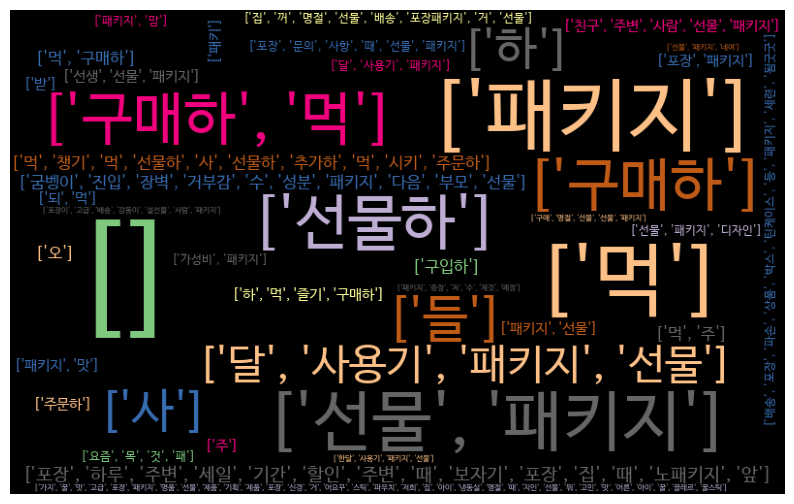

In [14]:
from collections import Counter
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import pandas as pd
# '패키지'와 연관된 리뷰 추출
reviews_related_to_package = df[df['리뷰'].str.contains('패키지')]

# 명사 컬럼과 용언 컬럼을 합침
combined_words = reviews_related_to_package['token_nouns'].tolist() + reviews_related_to_package['token_verbs'].tolist()

# 불용어 제거
combined_words = [word for word in combined_words if word not in stop_words]

# 워드클라우드 함수
def wc_analysis(data):
    words = dict(Counter(data).most_common(300))
    wordcloud = WordCloud(font_path='C:/Users/NT550/asac/SIH/SIH/Kurly/NanumBarunGothic.ttf', background_color='black', colormap="Accent_r",
                          width=800, height=500).generate_from_frequencies(words)
    plt.figure(figsize=(10, 10))
    plt.imshow(wordcloud)
    plt.axis('off')
    plt.show()

# 워드클라우드 생성
wc_analysis(combined_words)

In [ ]:
naver_shopping["ko_review"].tolist()

In [ ]:
# 형태소 벡터를 생성하기 위한 라이브러리
from sklearn.feature_extraction.text import CountVectorizer
# 형태소 벡터를 학습 벡터로 변환한다.
from sklearn.feature_extraction.text import TfidfTransformer

# 형태소 추출
index_vectorizer = CountVectorizer(tokenizer=lambda x : get_pos(x))
X = index_vectorizer.fit_transform(naver_shopping["ko_review"].tolist())

In [ ]:
index_vectorizer.vocabulary_

In [ ]:
# CountVectorizer로 생성한 형태소 벡터에서 단어 빈도수를 계산
word_frequencies = X.sum(axis=0)

# 각 단어와 빈도수를 매핑하는 딕셔너리 생성
word_frequency_dict = {}
for word, index in index_vectorizer.vocabulary_.items():
    word_frequency_dict[word] = word_frequencies[0, index]

# 빈도수가 큰 순서대로 정렬된 딕셔너리 생성
sorted_word_frequency_dict = dict(sorted(word_frequency_dict.items(), key=lambda item: item[1], reverse=True))

# 결과 출력
for word, frequency in sorted_word_frequency_dict.items():
    print(f"{word}: {frequency}")


In [ ]:
# 딕셔너리를 DataFrame으로 변환합니다.
#df = pd.DataFrame(list(sorted_word_frequency_dict.items()), columns=['Top Nouns', '빈도수'])

# DataFrame을 출력합니다.
df = pd.read_csv(r'C:\Users\NT550\asac\SIH\SIH\code2\result\naver_shopping_frequent.csv')
df.head()

In [ ]:
# "Top Nouns" 컬럼을 한글, 품사, 빈도수로 분리하여 새로운 컬럼 추가
df[['단어','품사']] = df['Top Nouns'].str.split('/', expand=True)
df = df[['단어', '품사', '빈도수']]

df.head()

In [ ]:
# 'NNP'와 'NNG'를 하나로 합치는 코드
combined_pos = ['NNP', 'NNG']

df.loc[df['품사'].isin(combined_pos), '품사'] = 'NNG/NNP'

df

In [ ]:
shopping_n = df[df['품사'] == 'NNG/NNP']
shopping_v = df[df['품사'] == 'VV']
shopping_a = df[df['품사'] == 'VA']
shopping_a

In [ ]:
with pd.option_context('display.max_rows', None, 'display.max_columns', None):
    print(shopping_a[:100])
    

In [ ]:
with pd.option_context('display.max_rows', None, 'display.max_columns', None):
    print(shopping_v[:100])
    


In [ ]:
# df_n을 실행할 때만 모든 행과 열 출력 설정 적용
with pd.option_context('display.max_rows', None, 'display.max_columns', None):
    print(shopping_n)


In [ ]:
shopping_n.to_excel('쇼핑_명사_all.xlsx')

In [ ]:
df_nouns = pd.read_csv(r'C:\Users\NT550\asac\SIH\SIH\code2\code\shopping_nouns.csv')
df_nouns.head()

### 불용어 처리

In [ ]:
df_nouns.info()

In [ ]:
# 조건에 맞게 처리하는 함수
def process_tokens(token_list):
    processed_tokens = []
    for token in token_list:
        if len(token) == 1:
            continue
        if '꿀' in token and '스틱' in token:
            processed_tokens.append('꿀스틱')
        else:
            processed_tokens.append(token)
    return processed_tokens

# 'processed_tokens' 열 생성
df_nouns['processed_tokens'] = df_nouns['token_nouns'].apply(process_tokens)

# 결과 출력
df_nouns['processed_tokens']

### 네이버 지식인 토큰화

In [ ]:
df = pd.read_excel(r'C:\Users\NT550\asac\SIH\SIH\code2\result\네이버지식인.xlsx')
print(len(df))
df.head()

In [ ]:
# 모든 컬럼에 '꿀'이라는 단어가 없는 행을 필터링합니다.
filtered_df = df[~(df['제목'].str.contains('꿀', na=False) &
                  df['질문'].str.contains('꿀', na=False) &
                  df['답변'].str.contains('꿀', na=False))]

# 결과를 출력합니다.
filtered_df[['제목','질문', '답변']].to_excel('네이버 지식인_제목,질문,답변.xlsx')

In [ ]:
# 리뷰 출력시 ... 없이 전부 나오게 설정
pd.set_option('display.max_colwidth', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_rows', None)

In [ ]:
filtered_df[['질문', '답변']]

In [ ]:
filtered_df["ko_review"] = filtered_df["답변"].apply(lambda x : text_clearing(x))

In [ ]:
# 형태소 벡터를 생성하기 위한 라이브러리
from sklearn.feature_extraction.text import CountVectorizer
# 형태소 벡터를 학습 벡터로 변환한다.
from sklearn.feature_extraction.text import TfidfTransformer

# 형태소 추출
index_vectorizer = CountVectorizer(tokenizer=lambda x : get_pos(x))
X = index_vectorizer.fit_transform(filtered_df["ko_review"].tolist())

In [ ]:
index_vectorizer.vocabulary_

In [ ]:
# CountVectorizer로 생성한 형태소 벡터에서 단어 빈도수를 계산
word_frequencies = X.sum(axis=0)

# 각 단어와 빈도수를 매핑하는 딕셔너리 생성
word_frequency_dict = {}
for word, index in index_vectorizer.vocabulary_.items():
    word_frequency_dict[word] = word_frequencies[0, index]

# 빈도수가 큰 순서대로 정렬된 딕셔너리 생성
sorted_word_frequency_dict = dict(sorted(word_frequency_dict.items(), key=lambda item: item[1], reverse=True))

# 결과 출력
for word, frequency in sorted_word_frequency_dict.items():
    print(f"{word}: {frequency}")


In [ ]:
# 딕셔너리를 DataFrame으로 변환합니다.
df_brain = pd.DataFrame(list(sorted_word_frequency_dict.items()), columns=['Top Nouns', '빈도수'])

# DataFrame을 출력합니다.
df_brain.head()

In [ ]:
# "Top Nouns" 컬럼을 한글, 품사, 빈도수로 분리하여 새로운 컬럼 추가
df_brain[['단어','품사']] = df_brain['Top Nouns'].str.split('/', expand=True)
df_brain = df_brain[['단어', '품사', '빈도수']]

df_brain.head()

In [ ]:
# 'NNP'와 'NNG'를 하나로 합치는 코드
combined_brain = ['NNP', 'NNG']

df_brain.loc[df_brain['품사'].isin(combined_brain), '품사'] = 'NNG/NNP'

df_brain.head()

In [ ]:
df_brain.to_csv('naver_brain_frequent.csv')

In [ ]:
df_n = df_brain[df_brain['품사'] == 'NNG/NNP']
df_v = df_brain[df_brain['품사'] == 'VV']
df_a = df_brain[df_brain['품사'] == 'VA']
df_n.head()

In [ ]:
# df_n을 실행할 때만 모든 행과 열 출력 설정 적용
with pd.option_context('display.max_rows', None, 'display.max_columns', None):
    print(df_a[:100])

In [ ]:
# df_n을 실행할 때만 모든 행과 열 출력 설정 적용
with pd.option_context('display.max_rows', None, 'display.max_columns', None):
    print(df_v[:100])

In [ ]:
# df_n을 실행할 때만 모든 행과 열 출력 설정 적용
with pd.option_context('display.max_rows', None, 'display.max_columns', None):
    print(df_n[:100])
df_n[:100].to_excel('지식인_명사.xlsx')
df_v[:100].to_excel('지식인_동사.xlsx')
df_a[:100].to_excel('지식인_형용사.xlsx')

### 블로그 토큰화

In [ ]:
naver_blog = pd.read_csv(r'C:\Users\NT550\asac\SIH\hsw\finaldata\naver_blog_text_scaling_last_tokens.csv')
naver_blog.head()

In [ ]:
naver_blog["str_content"] = naver_blog["변환된 내용"].apply(lambda x : text_clearing(x))

In [ ]:
# 'token'이라는 새로운 컬럼 추가 및 값 할당
naver_blog['token'] = naver_blog['str_content'].apply(lambda x: tagger.pos(x))

# 결과 확인
naver_blog['token']

In [ ]:
# 형태소 추출
index_vectorizer = CountVectorizer(tokenizer=lambda x : get_pos(x))
X = index_vectorizer.fit_transform(naver_blog["str_content"].tolist())
X

In [ ]:
index_vectorizer.vocabulary_

In [ ]:
# CountVectorizer로 생성한 형태소 벡터에서 단어 빈도수를 계산
word_frequencies = X.sum(axis=0)

# 각 단어와 빈도수를 매핑하는 딕셔너리 생성
word_frequency_dict = {}
for word, index in index_vectorizer.vocabulary_.items():
    word_frequency_dict[word] = word_frequencies[0, index]

# 빈도수가 큰 순서대로 정렬된 딕셔너리 생성
sorted_word_frequency_dict = dict(sorted(word_frequency_dict.items(), key=lambda item: item[1], reverse=True))

# 결과 출력
for word, frequency in sorted_word_frequency_dict.items():
    print(f"{word}: {frequency}")

In [ ]:
# 딕셔너리를 DataFrame으로 변환합니다.
blog = pd.DataFrame(list(sorted_word_frequency_dict.items()), columns=['토큰', '빈도수'])

# DataFrame을 출력합니다.
blog.to_csv('naver_blog.frequent.csv')

In [ ]:
result = []

for idx, value in blog['토큰'].iteritems():
    word = value.split('/')[0]
    pos = value.split('/')[1]
    result.append([word, pos])

df_blog = pd.DataFrame(result, columns=['단어', '품사'])

# 결과 출력
df_blog

In [ ]:
naver_blog = pd.read_csv(r'C:\Users\NT550\asac\SIH\SIH\code2\result\naver_shopping_tokenizer.csv')
naver_blog.head()

In [ ]:
# 명사, 동사, 형용사 품사 태그 정의
nouns_tags = ['NNG','NNP'] # NNG, NNP, 
verbs_tags = ['VV'] # VV
adjectives_tags = ['VA'] # VA

# 각 품사를 추출하여 열 추가
naver_blog['nouns'] = naver_blog['token'].apply(lambda x: [word for word, tag in x if tag in nouns_tags])
naver_blog['verbs'] = naver_blog['token'].apply(lambda x: [word for word, tag in x if tag in verbs_tags])
naver_blog['adjectives'] = naver_blog['token'].apply(lambda x: [word for word, tag in x if tag in adjectives_tags])

# 결과 출력
print(naver_blog[['nouns', 'verbs', 'adjectives']])

In [ ]:
df_blog[df_blog['품사'] == 'VA']

### 형태소 분석기 비교
- bareun VS kiwi


In [ ]:
bareun = pd.read_csv(r"C:\Users\NT550\asac\SIH\SIH\code2\result\naver_blog_tokenizer.csv")
kiwi = pd.read_csv(r"C:\Users\NT550\asac\SIH\hsw\finaldata\naver_blog_text_scaling_last_tokens.csv")

In [ ]:
bareun

In [ ]:
# 명사, 동사, 형용사 품사 태그 정의
nouns_tags = ['NNG', 'NP', 'NNP','NNB','NF','NA']
verbs_tags = ['VV','VX','VCP','VCN','NV']
adjectives_tags = ['VA']

# 각 품사를 추출하여 열 추가
naver_blog['nouns'] = naver_blog['token'].apply(lambda x: [word for word, tag in x if tag in nouns_tags])
naver_blog['verbs'] = naver_blog['token'].apply(lambda x: [word for word, tag in x if tag in verbs_tags])
naver_blog['adjectives'] = naver_blog['token'].apply(lambda x: [word for word, tag in x if tag in adjectives_tags])

# 결과 출력
print(naver_blog[['nouns', 'verbs', 'adjectives']])

### 연관분석